# **FNN**
- Using data that was not annotated
- Training it on the unbalanced data
- Using avgpool
- 6 second window

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import pygame
import time
from scipy.signal import butter, filtfilt
import random

In [212]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/split_features_2s_all.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [213]:
train_data = data['train'].copy()
val_data = data['val'].copy()

In [214]:
train_data

{'melspectrogram': array([[3.6285463e-05, 3.8200385e-05, 4.0739291e-05, ..., 3.0273466e-06,
         2.2592510e-06, 2.1416045e-06],
        [7.4347768e-09, 8.2490290e-09, 9.6704795e-09, ..., 2.0450429e-07,
         2.5535245e-08, 2.3674612e-08],
        [1.6406947e-06, 1.6677786e-06, 1.7138188e-06, ..., 2.2908193e-06,
         1.6840297e-06, 1.5936671e-06],
        ...,
        [2.7316248e-06, 2.9339224e-06, 3.2875062e-06, ..., 1.0139429e-06,
         5.8416873e-07, 5.6021997e-07],
        [2.4674987e-06, 2.5058257e-06, 2.5689174e-06, ..., 9.9417584e-06,
         2.3140782e-07, 1.8963851e-07],
        [3.0352521e-06, 4.1363774e-06, 6.0993666e-06, ..., 2.6265046e-05,
         7.4409758e-07, 7.3155365e-07]], dtype=float32),
 'mfcc': array([[-1.0000000e+00, -2.3037937e-01, -5.0594997e-01, ...,
          2.8443993e-03,  1.4909296e-02,  8.9377072e-03],
        [-1.0000000e+00, -2.6351056e-01, -5.3618097e-01, ...,
          5.8985357e-03,  1.1296259e-02,  1.5974644e-03],
        [-1.0000000e

In [215]:
train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

In [216]:
val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

# Shuffle Data

In [217]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [218]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [219]:
val_y, val_features = shuffle_data(val_labels, v_features)

In [220]:
display(train_y.shape)
display(train_y[:15])

(22631,)

array([16, 18, 16,  8,  0,  7,  1, 13,  5,  0,  0, 10,  0,  3,  0],
      dtype=int32)

In [221]:
for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'melspectrogram'

(22631, 60)

array([3.4329585e-06, 3.5621692e-06, 3.7917514e-06, 4.1497665e-06,
       4.7353369e-06, 6.1132328e-06, 1.1151645e-05, 3.9353021e-05,
       3.6168797e-04, 1.5898738e-02, 8.7700933e-02, 3.1693410e-02,
       6.7264899e-03, 1.9934600e-02, 6.2744088e-02, 1.4736451e-01,
       2.4715923e-01, 4.3244416e-01, 6.4362824e-01, 7.3113507e-01,
       6.8003190e-01, 5.6165701e-01, 5.0011736e-01, 4.7874513e-01,
       4.9124286e-01, 4.3701285e-01, 3.3579260e-01, 2.3378754e-01,
       1.5629211e-01, 7.9104789e-02, 4.6607573e-02, 2.8233325e-02,
       2.3269402e-02, 2.1181842e-02, 1.6698154e-02, 1.0057325e-02,
       7.4147303e-03, 5.1149242e-03, 3.2818515e-03, 2.6066876e-03,
       2.0486056e-03, 1.5702612e-03, 1.3500779e-03, 1.2921348e-03,
       1.4930066e-03, 8.4594055e-04, 7.1877841e-04, 6.1083917e-04,
       5.5965967e-04, 6.8108435e-04, 5.1947287e-04, 4.0253717e-04,
       2.7309530e-04, 1.7824488e-04, 7.9370431e-05, 1.4202556e-05,
       8.8283167e-07, 4.1159396e-08, 2.1225540e-08, 2.0640552e

'mfcc'

(22631, 20)

array([-1.        ,  0.06686971, -0.57930136, -0.21376139, -0.2327873 ,
        0.04279228, -0.08165312,  0.06095935, -0.036102  ,  0.0506189 ,
       -0.00393124,  0.03407677,  0.01182024,  0.02851278,  0.0287532 ,
       -0.00995063,  0.00625494, -0.01868421,  0.00853509, -0.02081537],
      dtype=float32)

'chroma'

(22631, 12)

array([0.60293585, 0.7147668 , 0.7193865 , 0.67120546, 0.58156115,
       0.5468347 , 0.5731501 , 0.54188204, 0.4656724 , 0.40363166,
       0.384592  , 0.4238847 ], dtype=float32)

'rms'

(22631, 1)

array([0.02097528], dtype=float32)

In [222]:
display(val_y.shape)
display(val_y[:15])

(6044,)

array([10,  2, 12,  0,  1, 18,  2,  2, 17,  2,  2,  2,  0, 17,  7],
      dtype=int32)

In [223]:
for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'melspectrogram'

(6044, 60)

array([8.3357208e-06, 8.4720250e-06, 8.7100416e-06, 9.0726417e-06,
       9.5879695e-06, 1.0466226e-05, 1.3052877e-05, 2.5488100e-05,
       7.8058765e-05, 2.7748491e-04, 1.2698962e-03, 8.1089614e-03,
       2.6884841e-02, 7.7197373e-02, 1.1425581e-01, 1.5141682e-01,
       2.0923702e-01, 2.1435727e-01, 2.4789700e-01, 2.3410201e-01,
       2.7105078e-01, 2.9080284e-01, 3.2453740e-01, 2.5168687e-01,
       2.6569101e-01, 3.2397676e-01, 3.5192734e-01, 3.7910870e-01,
       3.8736138e-01, 3.8108847e-01, 3.9733896e-01, 4.0133148e-01,
       3.4785292e-01, 2.9322231e-01, 2.5932199e-01, 2.6791215e-01,
       3.5579714e-01, 3.4876502e-01, 1.5109749e-01, 1.0652289e-01,
       7.9575814e-02, 6.9220871e-02, 6.0770944e-02, 5.9468258e-02,
       5.7272933e-02, 5.1554888e-02, 5.1538818e-02, 5.3031396e-02,
       5.8848843e-02, 5.2466441e-02, 5.0471891e-02, 6.2297914e-02,
       6.0394101e-02, 4.1807249e-02, 1.9994956e-02, 4.4141770e-03,
       2.8683330e-04, 6.7595729e-06, 1.3183726e-06, 1.1420557e

'mfcc'

(6044, 20)

array([-1.        , -0.1279752 , -0.42991543, -0.05328883, -0.14195837,
        0.05991282, -0.03893601,  0.12293213, -0.00933411,  0.06742494,
       -0.00383581, -0.00483967, -0.02284946, -0.01457014, -0.01093604,
       -0.0256334 ,  0.01997606, -0.00759161,  0.01483202, -0.00402587],
      dtype=float32)

'chroma'

(6044, 12)

array([0.50444525, 0.50069445, 0.4891589 , 0.45970854, 0.46573985,
       0.48136368, 0.57291734, 0.5993228 , 0.4840322 , 0.49154848,
       0.5054053 , 0.4910522 ], dtype=float32)

'rms'

(6044, 1)

array([0.0361241], dtype=float32)

## **FNN Model**

In [224]:
def build_model(input_features,
                hidden_layers=[128,64,32],
                learning_rate=0.0005,
                output_units=20,
                dropout_rate=0.2):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [225]:
def visualize(model_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [226]:
train_results = {}
val_results = {}

### **With all the features**

In [227]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['rms'], train_features['melspectrogram']), axis=1)
training_features.shape

(22631, 93)

In [228]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['rms'], val_features['melspectrogram']), axis=1)

validation_features.shape

(6044, 93)

Fit the model with training data

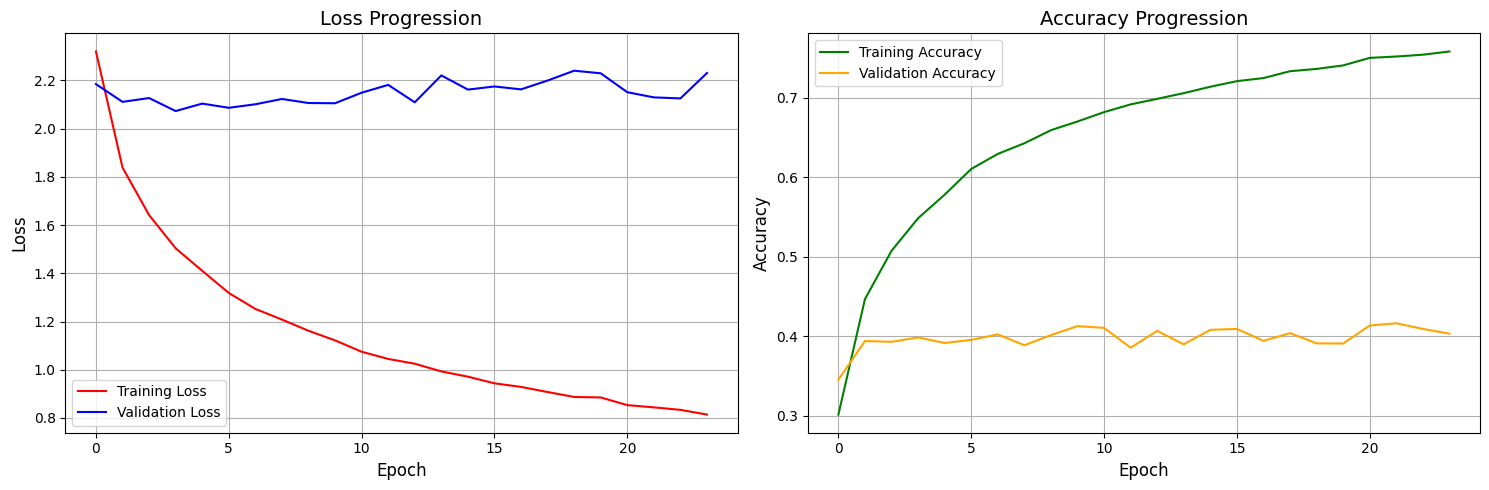

In [229]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_all_features_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [230]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6883 - loss: 1.1150
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4058 - loss: 2.0501


### **With MFCCs only**

In [231]:
training_features = train_features['mfcc']

training_features.shape

(22631, 20)

In [232]:
validation_features = val_features['mfcc']

validation_features.shape

(6044, 20)

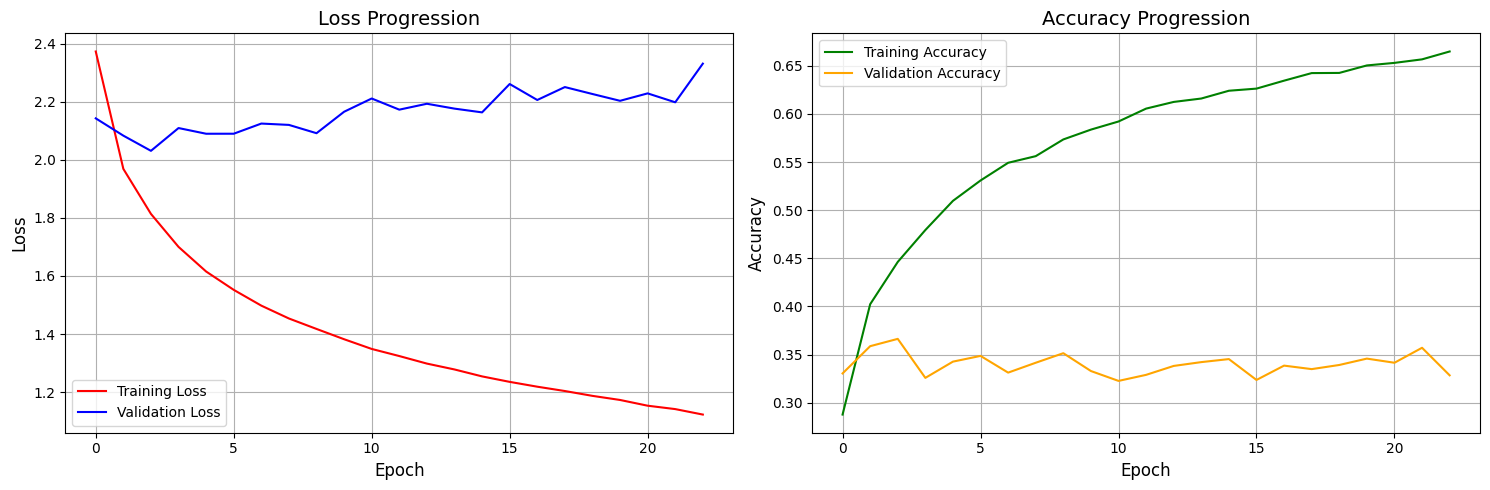

In [233]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [234]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5581 - loss: 1.4878
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3662 - loss: 2.0207


## **With MFCCs and Mel-Spectrogram**

In [235]:
training_features = np.concatenate((train_features['mfcc'], train_features['melspectrogram']), axis=1)

training_features.shape

(22631, 80)

In [236]:
validation_features = np.concatenate((val_features['mfcc'], val_features['melspectrogram']), axis=1)

validation_features.shape

(6044, 80)

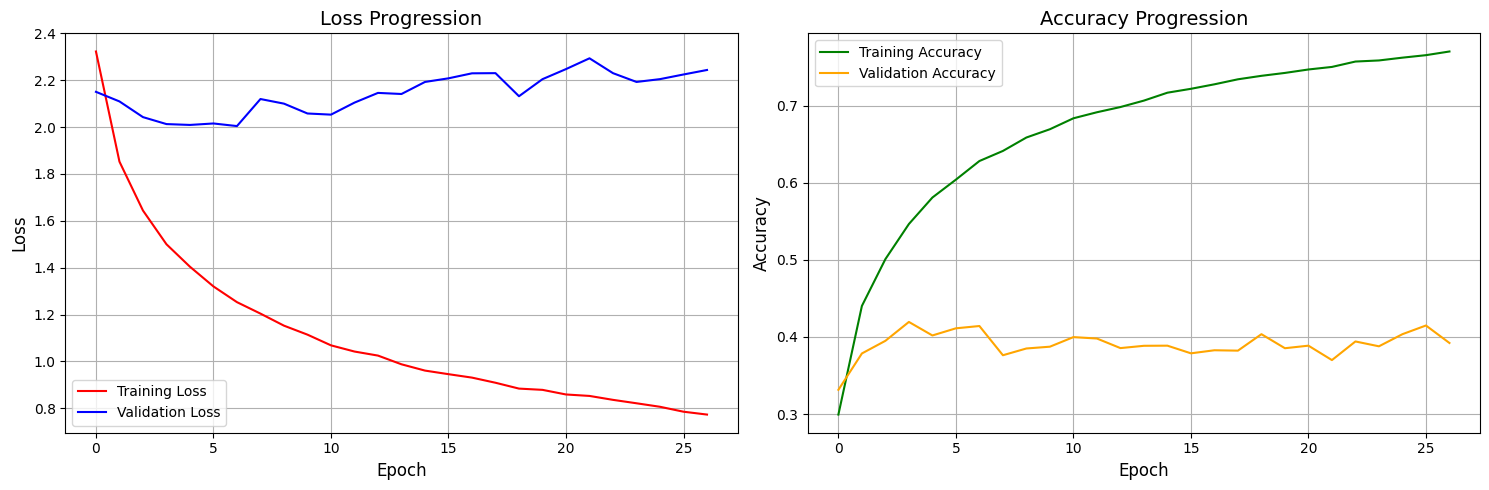

In [237]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_melspectrogram_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [238]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7520 - loss: 0.8831
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4192 - loss: 2.0014


## **With MFCCs and Chroma**

In [239]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma']), axis=1)

training_features.shape

(22631, 32)

In [240]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma']), axis=1)

validation_features.shape

(6044, 32)

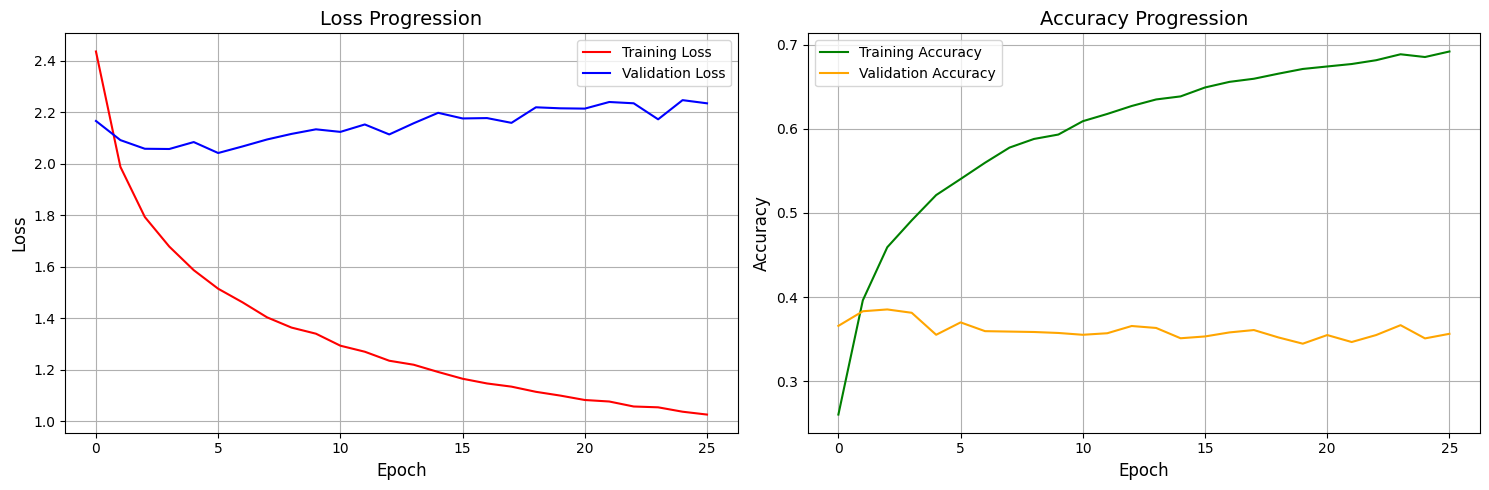

In [241]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_chroma_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [242]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_chroma'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6608 - loss: 1.1742
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3670 - loss: 2.0418


## **With MFCCs and RMS**

In [243]:
training_features = np.concatenate((train_features['mfcc'], train_features['rms']), axis=1)

training_features.shape

(22631, 21)

In [244]:
validation_features = np.concatenate((val_features['mfcc'], val_features['rms']), axis=1)

validation_features.shape

(6044, 21)

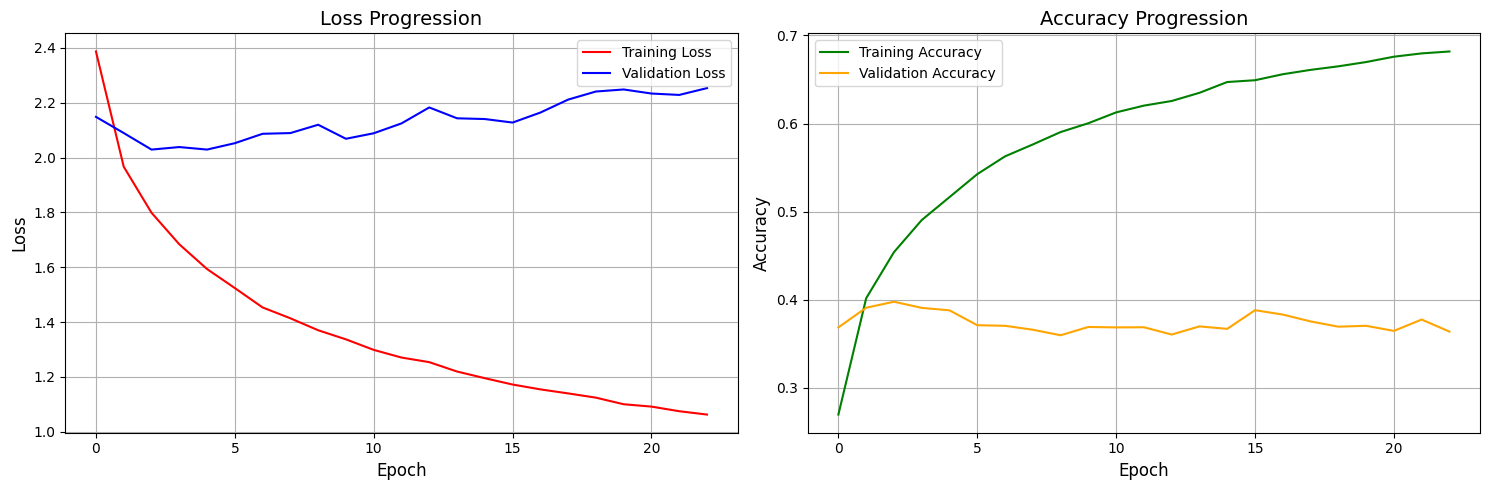

In [245]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_rms_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [246]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_rms'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_rms'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5744 - loss: 1.4607
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4017 - loss: 2.0170


## **With Mel-Spectrogram, MFCCs, RMS**

In [247]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['rms'], train_features['mfcc']), axis=1)

training_features.shape

(22631, 81)

In [248]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['rms'], val_features['mfcc']), axis=1)

validation_features.shape

(6044, 81)

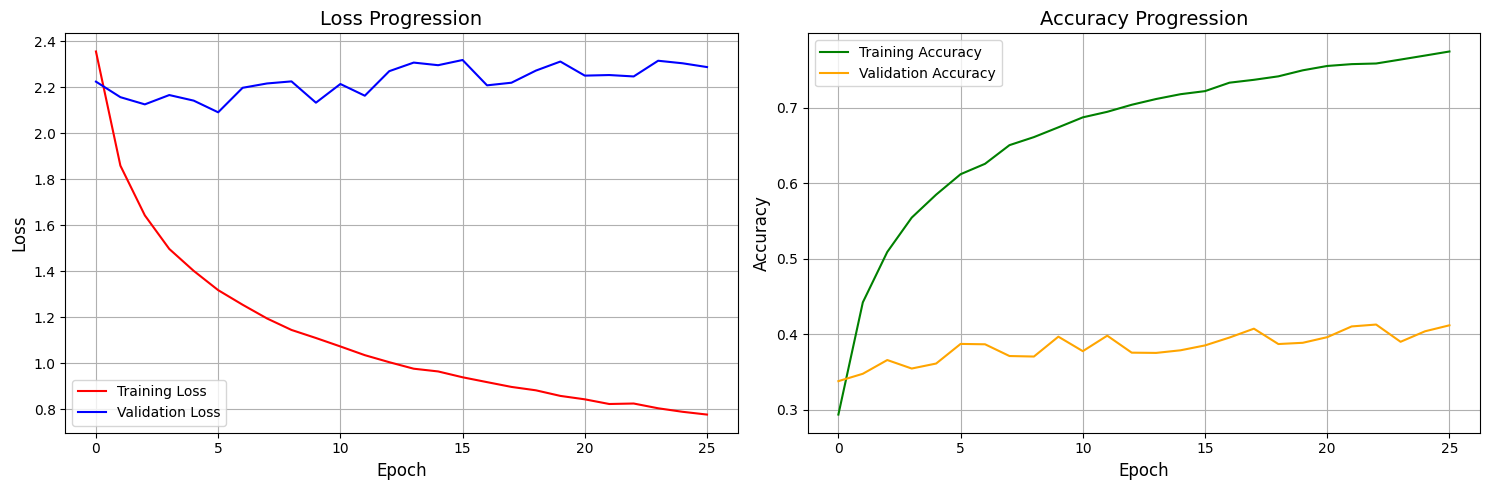

In [249]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_melspectrogram_rms_mfcc_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [250]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_rms_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_rms_mfcc'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7416 - loss: 0.9330
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3850 - loss: 2.0887


## **With Mel-Spectrogram, MFCCs, Chroma**

In [251]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)

training_features.shape

(22631, 92)

In [252]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)

validation_features.shape

(6044, 92)

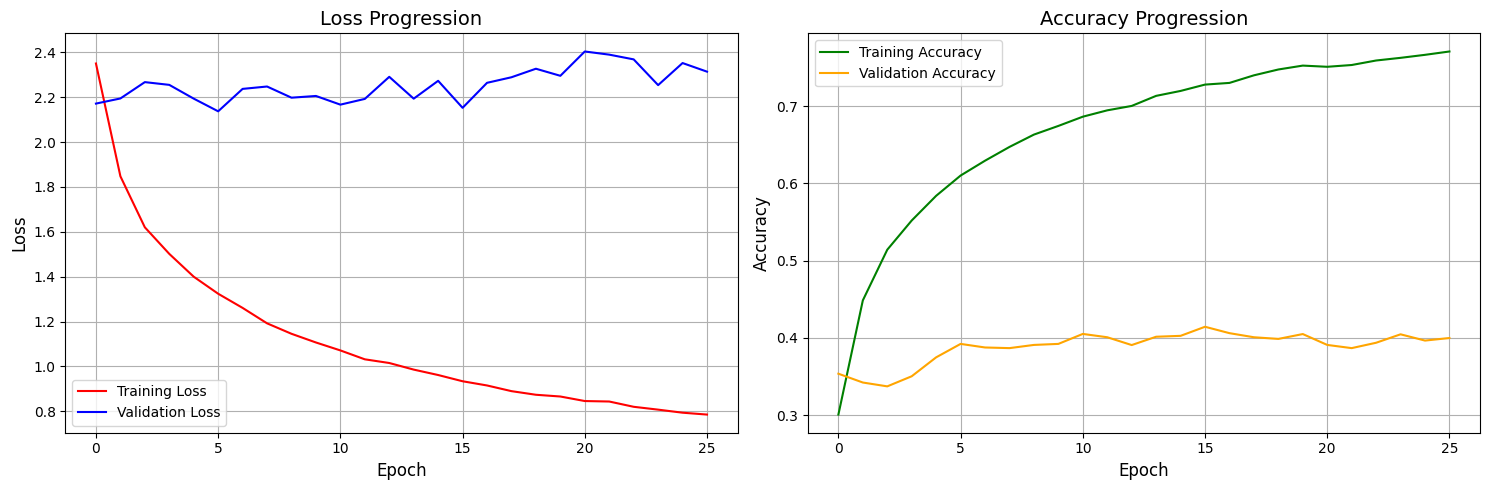

In [253]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_melspectrogram_chroma_mfcc_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [254]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7427 - loss: 0.9337
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4036 - loss: 2.1301


# Review results from all models

In [255]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.68,0.40
6,melspectrogram_chroma_mfcc,0.74,0.39
5,melspectrogram_rms_mfcc,0.74,0.39
1,mfcc,0.56,0.37
3,mfcc_chroma,0.66,0.37
2,mfcc_melspectrogram,0.75,0.41
4,mfcc_rms,0.57,0.40
